In [2]:
import copy
import json
import pickle

import gym
from gym_minigrid.minigrid import Grid
from gym_minigrid.wrappers import FullyObsWrapper, ReseedWrapper, RGBImgObsWrapper
import matplotlib.pylab as plt
import numpy as np
from PIL import Image
import pytorch_ssim
import seaborn as sns
import sklearn
from skimage.transform import resize, rescale, downscale_local_mean
from skimage.util import img_as_ubyte
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
import torch.nn as nn

from rlpyt.envs.gym import make as gym_make
from rlpyt.models.dqn.grid_dsr_model import FeatureDSRModel, InverseDynamicsModel, ForwardPixelModel, ForwardFeatureModel
from rlpyt.utils.seed import set_seed

device = torch.device('cuda', 0)


def plot_img(tensor, gray=True):
    if gray:
        plt.imshow(img_as_ubyte(tensor.detach().cpu().numpy().squeeze(2)), cmap='gray')
    else:
        plt.imshow(img_as_ubyte(tensor.detach().cpu().numpy()))

In [3]:
GRID_SIZE = 19


def generate_dsr_grid(sr_matrix, starting_pos=(1, 8)):
    starting_sr = sr_matrix[starting_pos]
    grid = np.zeros((GRID_SIZE, GRID_SIZE))
    for y in range(GRID_SIZE):
        for x in range(GRID_SIZE):
            if isinstance(sr_matrix, np.ndarray):
                grid[y, x] = np.linalg.norm(sr_matrix[y, x] - starting_sr, 2)
            else:
                grid[y, x] = torch.norm(sr_matrix[y, x] - starting_sr, 2)
    return grid.T


def visualize_dsr(sr_file, starting_pos=(1, 8), action=-1, normalize=True):
    sr = np.load(sr_file)
    if len(sr.shape) == 5:
        sr = sr.mean(axis=2)
    if action == -1:
        if isinstance(sr, np.ndarray):
            sr_matrix = sr.mean(axis=2)
        else:
            sr_matrix = sr.mean(dim=2)
    else:
        sr_matrix = sr[:, :, action]
    if normalize:
        if isinstance(sr_matrix, np.ndarray):
            sr_matrix = sr_matrix / np.linalg.norm(sr_matrix, axis=2).reshape(GRID_SIZE, GRID_SIZE, 1)
        else:
            sr_matrix = sr_matrix / torch.norm(sr_matrix, dim=2).reshape(GRID_SIZE, GRID_SIZE, 1)
    grid = generate_dsr_grid(sr_matrix, starting_pos)
    return sr_matrix, grid

/home/choang/anaconda3/envs/rlpyt/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


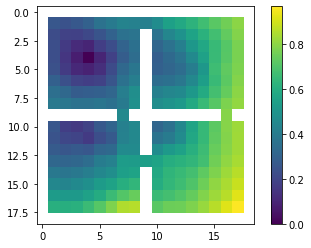

In [5]:
dsr, dsr_heatmap = visualize_dsr('../experiments/aux-data/inverse-features-10k.npy', (4, 4), -1, True)
plt.imshow(dsr_heatmap)
plt.colorbar()

In [4]:
env_id = 'MiniGrid-FourRooms-v0'
mode = 'image'
set_seed(333)
env = gym_make(id=env_id, mode=mode, minigrid_config={'size': [19, 19], 'grayscale': False})
obs = env.reset()

using seed 333


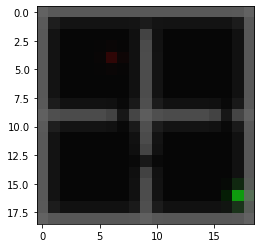

In [5]:
plt.imshow(obs)
obs = env.step(2)[0]

### Collect data

#### Transitions

In [29]:
positions = set()
for y in range(19):
    for x in range(19):
        if x not in [0, 9, 18] and y not in [0, 9, 18]:
            for action in range(4):
                env.env.env.unwrapped.agent_pos = np.array([y, x])
                _, _, done, _ = env.step(action)

                pos = tuple(env.agent_pos)
                if pos not in positions:
                    positions.add(pos)

                if done:
                    env.reset()

In [30]:
len(positions)

260

expect 260 * 4 * 4 = 4160 unique transitions

In [31]:
seen_states = set()
unique_states = []

seen_transitions = []
states = []
actions = []
next_states = []

In [33]:
for pos in positions:
    for direction in range(4):
        for a in range(4):
            env.env.env.unwrapped.agent_pos = np.array(pos)
            env.env.env.unwrapped.agent_dir = direction
            
            prev_obs, _, _, _ = env.step(4)
            
            obs, _, done, _ = env.step(a)
            
            new_pos = tuple(env.env.env.unwrapped.agent_pos)
            
            transition = (*pos, direction, a, *new_pos)
            if transition not in seen_transitions:
                seen_transitions.append(transition)
                states.append(torch.Tensor(prev_obs))
                actions.append(a)
                next_states.append(torch.Tensor(obs))
                
            state = (*pos, direction)
            
            if state not in seen_states:
                seen_states.add(state)
                unique_states.append(torch.Tensor(prev_obs))

            if done:
                env.reset()

In [25]:
len(seen_transitions)

4160

In [34]:
np.save('transitions', np.array(seen_transitions))

In [133]:
unique_states = torch.stack(unique_states)
unique_states = unique_states.to(device)
torch.save(unique_states, 'unique_states.pt')

In [134]:
states = torch.stack(states)
states = states.to(device)
torch.save(states, 'states.pt')

In [135]:
next_states = torch.stack(next_states)
next_states = next_states.to(device)
torch.save(next_states, 'next_states.pt')

In [136]:
actions = torch.LongTensor(actions)
actions = actions.to(device)
torch.save(actions, 'actions.pt')

### Inverse Dynamics

#### Toy Experiment

In [50]:
env.reset()
env.env.env.unwrapped.agent_pos = np.array([1, 1])
obs = env.step(0)[0]

In [51]:
states = torch.stack([torch.Tensor(obs) for _ in range(4)])
states = states.to(device)

In [52]:
next_states = []
for pos in [[1, 1], [1, 17], [17, 1], [17, 17]]:
    env.reset()
    env.env.env.unwrapped.agent_pos = np.array(pos)
    obs = env.step(0)[0]
    next_states.append(torch.Tensor(obs))
next_states = torch.stack(next_states)
next_states = next_states.to(device)

In [53]:
actions = torch.LongTensor([i for i in range(4)])
actions = actions.to(device)

#### Actual inverse dynamics

In [50]:
states = torch.load('states.pt', map_location=device)
# states = states.unsqueeze(3)
next_states = torch.load('next_states.pt', map_location=device)
# next_states = next_states.unsqueeze(3)
actions = torch.load('actions.pt', map_location=device)

In [53]:
model = InverseDynamicsModel(env.observation_space.shape, 4, 64)
model.to(device)

InverseDynamicsModel(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Flatten()
    (5): Linear(in_features=784, out_features=64, bias=True)
  )
  (inverse): Sequential(
    (0): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [56]:
N = states.size()[0]
learning_rate = 1e-3
epochs = 20000
batch_size = N
optim_kwargs = dict(eps=0.01 / batch_size)
clip_grad_norm = 10
log_interval = 1000

In [57]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, **optim_kwargs)
cross_entropy_loss = nn.CrossEntropyLoss()
losses = []
accuracies = []
grad_norms = []

In [58]:
for epoch in range(epochs):

    permutation = torch.randperm(N)
    
    epoch_losses = []
    epoch_accuracies = []
    epoch_grad_norms = []
    
    for i in range(0, N, batch_size):
        optimizer.zero_grad()
        
        indices = permutation[i: i + batch_size]

        pred_actions = model(states[indices], next_states[indices], mode='inverse')
        loss = cross_entropy_loss(pred_actions, actions[indices])

        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)

        optimizer.step()
        
        accuracy = ((pred_actions.argmax(dim=1) == actions[indices]).sum().float() / actions[indices].shape[0]) * 100
        
        epoch_losses.append(loss.item())
        epoch_accuracies.append(accuracy.item())
        epoch_grad_norms.append(grad_norm)
        
    losses.append(np.mean(epoch_losses))
    accuracies.append(np.mean(epoch_accuracies))
    grad_norms.append(np.mean(epoch_grad_norms))
    
    if epoch % log_interval == 0:
        print('Epoch {}: loss = {}, accuracy = {}%'.format(epoch, np.mean(epoch_losses), np.mean(epoch_accuracies)))

Epoch 0: loss = 1.388809323310852, accuracy = 25.0%
Epoch 1000: loss = 0.284857839345932, accuracy = 91.4903793334961%
Epoch 2000: loss = 0.08748753368854523, accuracy = 97.40384674072266%
Epoch 3000: loss = 0.055454615503549576, accuracy = 97.98076629638672%
Epoch 4000: loss = 0.041164882481098175, accuracy = 98.41345977783203%
Epoch 5000: loss = 0.03343220800161362, accuracy = 98.53365325927734%
Epoch 6000: loss = 0.028177279978990555, accuracy = 98.65384674072266%
Epoch 7000: loss = 0.02535593882203102, accuracy = 98.72595977783203%
Epoch 8000: loss = 0.022828703746199608, accuracy = 98.89423370361328%
Epoch 9000: loss = 0.021360596641898155, accuracy = 98.91827392578125%
Epoch 10000: loss = 0.019339274615049362, accuracy = 99.0144271850586%
Epoch 11000: loss = 0.01745794154703617, accuracy = 99.18269348144531%
Epoch 12000: loss = 0.01705855131149292, accuracy = 99.18269348144531%
Epoch 13000: loss = 0.01546755712479353, accuracy = 99.25480651855469%
Epoch 14000: loss = 0.0141011411

KeyboardInterrupt: 

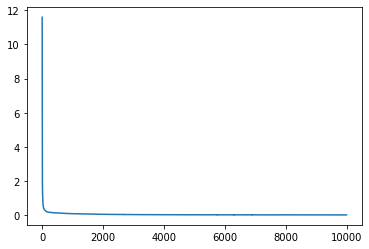

In [187]:
plt.plot(losses)

In [ ]:
plt.plot(grad_norms)

In [ ]:
plt.plot(accuracies)

In [ ]:
torch.save(model.state_dict(), 'models/inverse-model-20k.pt')

### Forward Dynamics

In [7]:
states = torch.load('states.pt', map_location=device)
# states = states.unsqueeze(3)
next_states = torch.load('next_states.pt', map_location=device)
# next_states = next_states.unsqueeze(3)
actions = torch.load('actions.pt', map_location=device)

In [6]:
inverse_model = InverseDynamicsModel(env.observation_space.shape, 4, 64)
inverse_model.load_state_dict(torch.load('models/inverse-model-10k.pt'))
inverse_model.to(device)

InverseDynamicsModel(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Flatten()
    (5): Linear(in_features=784, out_features=64, bias=True)
  )
  (inverse): Sequential(
    (0): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [61]:
# del model
model = ForwardFeatureModel(4, 64)
model.to(device)

ForwardFeatureModel(
  (dynamics): MlpModel(
    (model): Sequential(
      (0): Linear(in_features=68, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=64, bias=True)
    )
  )
)

In [62]:
N = states.size()[0]
learning_rate = 1e-3
epochs = 10000
batch_size = N
optim_kwargs = dict(eps=0.01 / batch_size)
clip_grad_norm = 10
log_interval = 1000

In [63]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, **optim_kwargs)
mse_loss = nn.MSELoss()
losses = []
grad_norms = []

In [64]:
for epoch in range(epochs):

    permutation = torch.randperm(N)
    
    epoch_losses = []
    epoch_grad_norms = []
    
    for i in range(0, N, batch_size):
        optimizer.zero_grad()
        
        indices = permutation[i: i + batch_size]

        with torch.no_grad():
            embeddings, next_embeddings = inverse_model(states[indices], next_states[indices], mode='encode')
        
        pred_embeddings = model(embeddings, actions[indices])
        loss = mse_loss(pred_embeddings, next_embeddings)
        
#         pred_next_states = model(states[indices], actions[indices], mode='dynamics')
#         loss = mse_loss(pred_next_states, next_states[indices])

        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)

        optimizer.step()
        
        epoch_losses.append(loss.item())
        epoch_grad_norms.append(grad_norm)
        
    losses.append(np.mean(epoch_losses))
    grad_norms.append(np.mean(epoch_grad_norms))
    
    if epoch % log_interval == 0:
        print('Epoch {}: loss = {}'.format(epoch, np.mean(epoch_losses)))

Epoch 0: loss = 11.588638305664062
Epoch 1000: loss = 0.08384840935468674
Epoch 2000: loss = 0.046794384717941284
Epoch 3000: loss = 0.034004077315330505
Epoch 4000: loss = 0.023008055984973907
Epoch 5000: loss = 0.020075183361768723
Epoch 6000: loss = 0.016420481726527214
Epoch 7000: loss = 0.018247853964567184
Epoch 8000: loss = 0.013518658466637135
Epoch 9000: loss = 0.018268713727593422


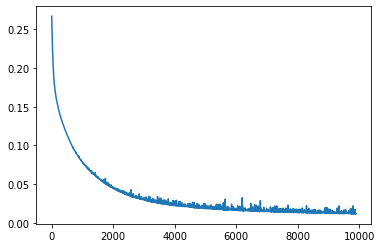

In [65]:
plt.plot(losses[100:])

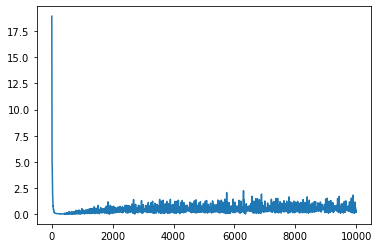

In [66]:
plt.plot(grad_norms)

In [67]:
torch.save(model.state_dict(), 'models/forward-model-10k.pt')

In [68]:
forward_model = ForwardFeatureModel(4, 64)
forward_model.load_state_dict(torch.load('models/forward-model-10k.pt'))
forward_model.to(device)

ForwardFeatureModel(
  (dynamics): MlpModel(
    (model): Sequential(
      (0): Linear(in_features=68, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=64, bias=True)
    )
  )
)

In [12]:
transitions = np.load('transitions.npy')

In [8]:
with torch.no_grad():
    features, _ = inverse_model(states, next_states, mode='encode')
features.shape

torch.Size([4160, 64])

In [13]:
norm_features = (features - features.min(dim=0).values) / (features.max(dim=0).values - features.min(dim=0).values)

In [14]:
feature_map = np.zeros((19, 19, 4, 64))
for i, transition in enumerate(transitions):
    feature_map[transition[0], transition[1], transition[2]] = norm_features[i].cpu().detach().numpy()

In [15]:
np.save('../experiments/aux-data/inverse-features-10k', feature_map)

In [11]:
pos = transitions[::16][:, :2]
rooms = np.zeros(260)
rooms[(pos[:, 0] < 9) & (pos[:, 1] < 9)] = 1
rooms[(pos[:, 0] < 9) & (pos[:, 1] > 9)] = 2
rooms[(pos[:, 0] > 9) & (pos[:, 1] < 9)] = 3
rooms[(pos[:, 0] > 9) & (pos[:, 1] > 9)] = 4

NameError: name 'transitions' is not defined

In [196]:
embeddings = norm_features[::16]
np_features = embeddings.cpu().detach().numpy()
tsne_features = TSNE(n_components=2).fit_transform(np_features)

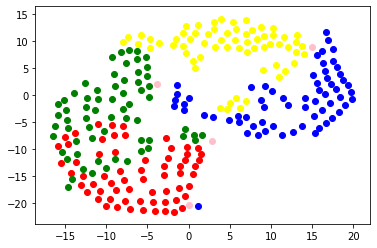

In [197]:
plt.scatter(tsne_features[rooms == 0][:, 0], tsne_features[rooms==0][:, 1], color='pink')
plt.scatter(tsne_features[rooms == 1][:, 0], tsne_features[rooms==1][:, 1], color='red')
plt.scatter(tsne_features[rooms == 2][:, 0], tsne_features[rooms==2][:, 1], color='green')
plt.scatter(tsne_features[rooms == 3][:, 0], tsne_features[rooms==3][:, 1], color='blue')
plt.scatter(tsne_features[rooms == 4][:, 0], tsne_features[rooms==4][:, 1], color='yellow')

In [76]:
with torch.no_grad():
    features, _ = inverse_model(states, next_states, mode='encode')
    next_features = forward_model(features, actions)

In [77]:
norm_next_features = (next_features - next_features.min(dim=0).values) / (next_features.max(dim=0).values - next_features.min(dim=0).values)

In [78]:
feature_map = np.zeros((19, 19, 4, 4, 64))

In [79]:
for i, transition in enumerate(transitions):
    feature_map[transition[0], transition[1], transition[2], transition[3]] = norm_next_features[i].cpu().detach().numpy()

In [81]:
np.save('../experiments/aux-data/forward-features-10k', feature_map)

In [255]:
reshaped_norm_next_features = norm_next_features[::4].reshape(260, 4, 64)[:, 0]

In [256]:
reshaped_next_features = next_features[::4].reshape(260, 4, 64)[:, 0]

In [259]:
embeddings = reshaped_next_features
np_features = embeddings.cpu().detach().numpy()
tsne_features = TSNE(n_components=2).fit_transform(np_features)

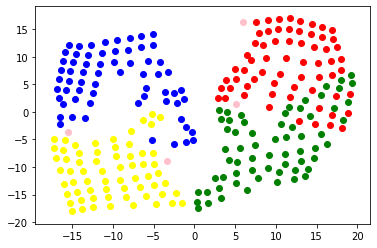

In [260]:
plt.scatter(tsne_features[rooms == 0][:, 0], tsne_features[rooms==0][:, 1], color='pink')
plt.scatter(tsne_features[rooms == 1][:, 0], tsne_features[rooms==1][:, 1], color='red')
plt.scatter(tsne_features[rooms == 2][:, 0], tsne_features[rooms==2][:, 1], color='green')
plt.scatter(tsne_features[rooms == 3][:, 0], tsne_features[rooms==3][:, 1], color='blue')
plt.scatter(tsne_features[rooms == 4][:, 0], tsne_features[rooms==4][:, 1], color='yellow')

### Initialization

In [62]:
dsr_params = {"fc_sizes": [512],
              "nonlinearity": "relu"}  

In [63]:
l2_loss = nn.MSELoss()

In [64]:
model = GridReconstructModel(env.observation_space.shape, env.action_space.n, 512, dsr_params)
model.to(device)

GridReconstructModel(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): Flatten()
    (7): Linear(in_features=2592, out_features=512, bias=True)
    (8): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=512, out_features=2592, bias=True)
    (1): ReLU()
    (2): Reshape()
    (3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(8, 3, kernel_size=(4, 4), stride=(2, 2))
  )
  (dsr): MlpModel(
    (model): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=1536, bias=True)
    )
  )
  (q_estimate): Linear(in_features=512, out_features=1, bias=True)
)

In [39]:
learning_rate = 1e-4
batch_size = data.shape[0]
epochs = 10000
optim_kwargs = dict(eps=0.01 / batch_size)
clip_grad_norm = 10
log_interval = 1000

NameError: name 'data' is not defined

In [66]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, **optim_kwargs)

In [67]:
losses = []
grad_norms = []

In [ ]:
for i in range(epochs):
    optimizer.zero_grad()
    
    embeddings = model(data, mode='encode')
    reconstructed = model(embeddings, mode='decode')
#     loss = l2_loss(reconstructed, data)
    loss = torch.mean(torch.norm(data - reconstructed, p=8))
    loss = torch.mean(torch.abs(data - reconstructed))
    
    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)

    optimizer.step()
    
    losses.append(loss.item())
    grad_norms.append(grad_norm)
    
    if i % log_interval == 0:
        print('Epoch {}: {}'.format(i, loss.item()))

Epoch 0: 0.05676276981830597
Epoch 1000: 0.0024810885079205036
Epoch 2000: 0.0012856796383857727
Epoch 3000: 0.0007588175358250737
Epoch 4000: 0.0004786360077559948
Epoch 5000: 0.00035500642843544483
Epoch 6000: 0.00029101831023581326
Epoch 7000: 0.00025442292098887265
Epoch 8000: 0.00023078525555320084
Epoch 9000: 0.00021538251894526184


In [ ]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [ ]:
plt.plot(grad_norms)
plt.xlabel('Epochs')
plt.ylabel('Gradient Norm')

### Testing

In [29]:
with torch.no_grad():
    embeddings = model(data, mode='encode')
    reconstructed = model(embeddings, mode='decode')

In [31]:
def rescale(data):
    return (data - data.min()) / (data.max() - data.min())

In [32]:
reconstructed = rescale(reconstructed)

In [36]:
reconstructed.shape

torch.Size([1040, 84, 84, 3])

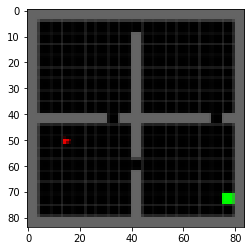

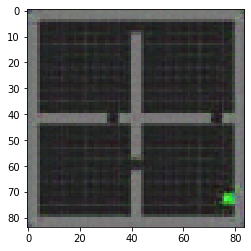

In [38]:
for idx in [300]:
    plt.figure()
    plot_img(data[idx], False)
    plt.figure()
    plot_img(reconstructed[idx], False)